Entrenamos un predictor de regresión lineal para hacer prediccion de mortalidad y lo evaluamos con AUROC

In [0]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt


#Necesitamos mostrar graficamente las areas de decision
#Definimos una funcion para mostrarlas (tomada de Rashka - Python Machine Learning)

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.01):

    # establecemos marcadores y colores
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('blue', 'red', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # mostramos la superficie de decision
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

    # destacamos los casos de test
    if test_idx is not None:
      if test_idx.shape[0]>0:
        # dibujamos todos
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100, 
                    label='test set')






In [11]:
#Importamos los datos de un fichero csv
import pandas as pd
df = pd.read_csv('ejemploMI.csv')
df.tail()


,Unnamed: 0,X,exitus,apache2,tipopaciente,sexopac,edad,sofa,lactato
1360,1364,1364,0,24,QU,Hombre,68,5,1.9
1361,1365,1365,0,18,QP,Hombre,55,5,1.5
1362,1366,1366,0,13,QP,Hombre,68,2,4.9
1363,1367,1367,0,10,QU,Hombre,33,1,1.1
1364,1368,1368,0,8,QP,Hombre,64,4,4.8


In [12]:
import matplotlib.pyplot as plt
import numpy as np               # primero un ejemplo sencillo con solo dos variables (apache y lactato)
#Utilizamos solo pacientes con tipo de ingreso medico o quirurgico urgente
X = df[(df['tipopaciente']=='QU') | (df['tipopaciente']=='M')].iloc[:,[2,3,8]].values    # la variable X tiene los valores de apache2 (columna 3), lactato (columna 8) y exitus (columna 2,variable resultado)
                                   

print("Clases target iniciales: ",np.unique(X[:,0]))


Clases target iniciales:  [0. 1.]


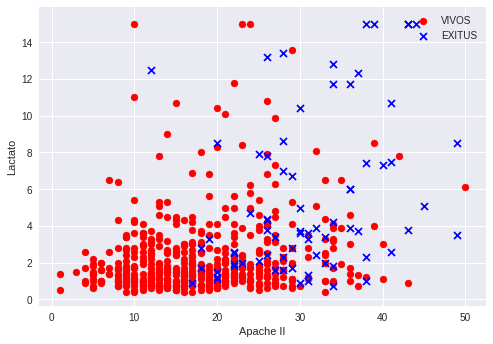

In [13]:
plt.scatter(X[X[:,0]==0,1],X[X[:,0]==0,2],color="red",marker="o",label="VIVOS")
plt.scatter(X[X[:,0]==1,1],X[X[:,0]==1,2],color="blue",marker="x",label="EXITUS")
plt.xlabel("Apache II")
plt.ylabel("Lactato")
plt.legend(loc="upper right")
plt.show()

In [14]:
#Vemos que hay un valor de lactato que se sale de la capacidad de medición del gasómetro (hasta 15). Lo eliminamos ya que es un único valor
df=df[df['lactato']<=15]
print('Lactato máximo',df['lactato'].max())
#Mostramos el apache2 minimo para exitus
print("Apache 2 minimo en exitus",df[df['exitus']==1]['apache2'].min())

Lactato máximo 15.0
Apache 2 minimo en exitus 12


Valores unicos de la clase target  [0 1]
Shapes: lasX:  579 ; laY:  579 ; indices:  579
      apache2  lactato
1148       20      1.9
780        15      1.5
671        22      2.2
12         21      1.3
576        14      1.0
Instancias de exitus: [  0 506  73]
Intancias en train: [  0 354  51]
Instancias en test: [  0 152  22]
Mal clasificados: 20
Bien clasificados: 154
Exitus predicho: 10
Vivo predicho: 164
Falsos exitus: 4
Falsos vivos: 16
Porcentaje de acierto: 0.89 ; si predecimos todos vivos sería del  0.8735632183908046


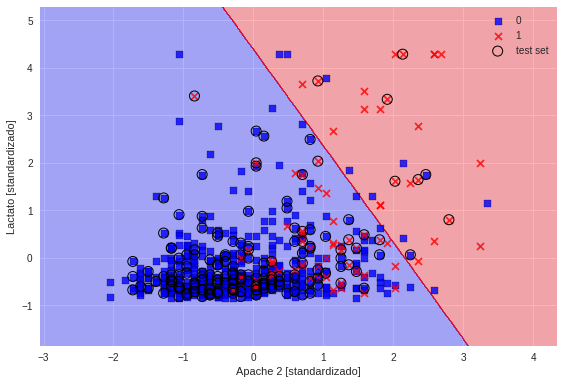

In [15]:
#Ahora entrenamos un predictor de regresión lineal y evaluamos su capacidad predictiva

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

#Usamos en este caso solo los pacientes de tipo medico o quirurgico urgente

lasX = df[(df['tipopaciente']=='QU') | (df['tipopaciente']=='M')].iloc[:,[3,8]]
laY = df[(df['tipopaciente']=='QU') | (df['tipopaciente']=='M')].iloc[:,2]
#laY = np.where(laY==1,-1,1)  En este caso usamos 0 y 1 como valores de las clases porque este predictor lo hace así
print("Valores unicos de la clase target ",np.unique(laY)) 

#Dividimos el dataframe en un set de training y otro de test, homogeneamente representados en cuanto al target
indices = np.arange(lasX.shape[0])

print("Shapes: lasX: ",lasX.shape[0], "; laY: ",laY.shape[0],"; indices: " ,indices.shape[0])
lasX_train,lasX_test,laY_train,laY_test,indexes_train,indexes_test = \
    train_test_split(lasX,laY,indices,test_size=0.3,random_state=None,stratify=df[(df['tipopaciente']=='QU') | (df['tipopaciente']=='M')]['exitus'].values)

print(lasX_test.tail())

print("Instancias de exitus:" , np.bincount(laY+1))
print("Intancias en train:" , np.bincount(laY_train+1))
print("Instancias en test:" , np.bincount(laY_test+1))

#Escalamos las variables
sc = StandardScaler()
sc.fit(lasX_train)
lasX_train_std=sc.transform(lasX_train)
lasX_test_std=sc.transform(lasX_test)

#Creamos el perceptron y lo entrenamos
lr1 = LogisticRegression(C=100.0)
lr1.fit(lasX_train_std,laY_train)

#Realizamos las predicciones y evaluamos
laY_pred = lr1.predict(lasX_test_std)
print('Mal clasificados: %d' % (laY_test!=laY_pred).sum())
print('Bien clasificados: %d' % (laY_test==laY_pred).sum())
print('Exitus predicho: %d' % (1==laY_pred).sum())
print('Vivo predicho: %d' % (0==laY_pred).sum())


print('Falsos exitus: %d' % ((laY_test==0)&(laY_pred==1)).sum())
print('Falsos vivos: %d' % ((laY_test==1)&(laY_pred==0)).sum())

print('Porcentaje de acierto: %.2f' % accuracy_score(laY_test,laY_pred), "; si predecimos todos vivos sería del ",1-laY_test.mean())

lasX_combined_std = np.vstack((lasX_train_std, lasX_test_std))
laY_combined = np.hstack((laY_train, laY_test))


plot_decision_regions(X=lasX_combined_std, y=laY_combined,
                      classifier=lr1, test_idx=indexes_test ) #indexes_test)  
plt.xlabel('Apache 2 [standardizado]')
plt.ylabel('Lactato [standardizado]')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [16]:
# Ahora añadimos otras variables al predictor: sofa al ingreso y edad

lasX2 = df[(df['tipopaciente']=='QU') | (df['tipopaciente']=='M')].iloc[:,[3,6,7,8]]  #sofa esta en la columna 7, edad en la 6
laY2 = df[(df['tipopaciente']=='QU') | (df['tipopaciente']=='M')].iloc[:,2]
#laY2 = np.where(laY==1,-1,1)   Usamos como clases 0 y 1

lasX2_train,lasX2_test,laY2_train,laY2_test = \
      train_test_split(lasX2,laY2,test_size=0.3,random_state=None,stratify=df[(df['tipopaciente']=='QU') | (df['tipopaciente']=='M')]['exitus'].values)

sc = StandardScaler()
sc.fit(lasX2_train)
lasX2_train_std=sc.transform(lasX2_train)
lasX2_test_std=sc.transform(lasX2_test)


lr2 = LogisticRegression(C=100.0)   # cambiamos algo los metaparametros
lr2.fit(lasX2_train_std,laY2_train)

print("Coeficientes: ",lr2.coef_,"; Intercept: " ,lr2.intercept_)

laY2_pred = lr2.predict(lasX2_test_std)
print('Mal clasificados: %d' % (laY2_test!=laY2_pred).sum())
print('Bien clasificados: %d' % (laY2_test==laY2_pred).sum())
print('Vivo predicho: %d' % (0==laY2_pred).sum())
print('Exitus predicho: %d' % (1==laY2_pred).sum())


print('Falsos vivos: %d' % ((laY2_test==1)&(laY2_pred==0)).sum())
print('Falsos exitus: %d' % ((laY2_test==0)&(laY2_pred==1)).sum())

print('Porcentaje de acierto: %.2f' % accuracy_score(laY2_test,laY2_pred), "; si predecimos todos vivos sería del ",1-laY_test.mean())

#Podemos usar el perceptron para clasificar nuevos casos
print(lr2.predict_proba(lasX2_test_std[:10,:]))
lr2.predict(lasX2_test_std[:10,:])




Coeficientes:  [[1.34675007 0.05666244 0.71356029 0.40453637]] ; Intercept:  [-3.13748987]
Mal clasificados: 23
Bien clasificados: 151
Vivo predicho: 161
Exitus predicho: 13
Falsos vivos: 16
Falsos exitus: 7
Porcentaje de acierto: 0.87 ; si predecimos todos vivos sería del  0.8735632183908046
[[0.96620813 0.03379187]
 [0.65515558 0.34484442]
 [0.94054827 0.05945173]
 [0.87399271 0.12600729]
 [0.89511889 0.10488111]
 [0.92172602 0.07827398]
 [0.99374691 0.00625309]
 [0.97994742 0.02005258]
 [0.76370203 0.23629797]
 [0.52932167 0.47067833]]


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

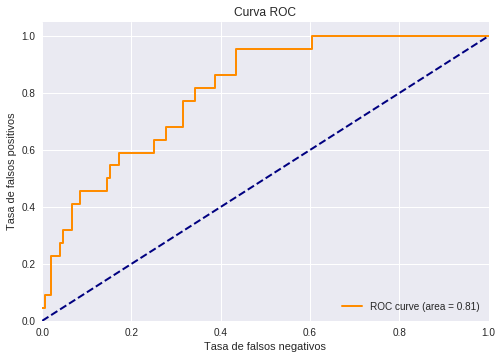

In [27]:
#Ahora evaluamos mediante AUROC

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split

y_score = lr2.decision_function(lasX2_test_std)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr[0], tpr[0], _ = roc_curve(laY2_test, y_score)
roc_auc[0] = auc(fpr[0], tpr[0])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(laY2_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


#Plot of a ROC curve for a specific class

plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de falsos negativos')
plt.ylabel('Tasa de falsos positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

In [26]:
#Evaluamos el modelo mediante k-fold cross-validation

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

pipe_lr = make_pipeline(StandardScaler(),
                        LogisticRegression(C=100.0))

scores = cross_val_score(estimator=pipe_lr,
                         X=lasX2_train,
                         y=laY2_train,
                         cv=10,
                         n_jobs=1)
print('CV accuracy scores training: %s' % scores)
print('CV accuracy training: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))




CV accuracy scores training: [0.9047619  0.85365854 0.85365854 0.90243902 0.85       0.925
 0.95       0.875      0.925      0.9       ]
CV accuracy training: 0.894 +/- 0.033


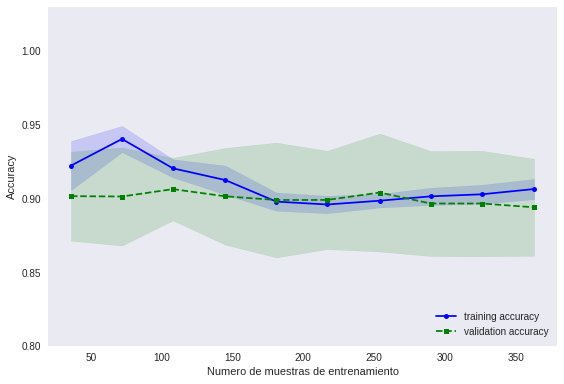

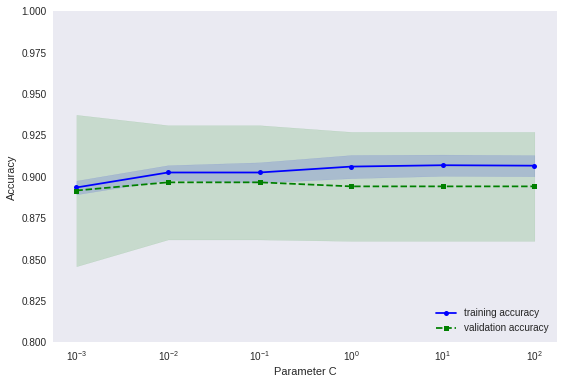

In [25]:
# Valoramos bias y varianza mediante curvas de aprendizaje
# Usamos pipelines


from sklearn.model_selection import learning_curve


train_sizes, train_scores, test_scores =                learning_curve(estimator=pipe_lr,
                               X=lasX2_train,
                               y=laY2_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,
                               n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Numero de muestras de entrenamiento')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
#plt.savefig('images/06_05.png', dpi=300)
plt.show()

# Evaluamos el valor optimo de C mediante curvas de validacion

from sklearn.model_selection import validation_curve


param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(
                estimator=pipe_lr, 
                X=lasX2_train, 
                y=laY2_train, 
                param_name='logisticregression__C', 
                param_range=param_range,
                cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='validation accuracy')

plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.tight_layout()
# plt.savefig('images/06_06.png', dpi=300)
plt.show()
